In [ ]:
import pandas as pd
from datetime import datetime 
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from src.detectors import LSHiForest
import data_loader as dl
import config
import numpy as np

num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), 
    ("L1SH", LSHiForest('L1SH', num_ensemblers)),
    ("L2SH", LSHiForest('L2SH', num_ensemblers)), 
    ("ALSH", LSHiForest('ALSH', num_ensemblers))
    ]

In [ ]:
# dataのロード:cic
X_train, y_train, X_test, y_test_cat = dl.load_cic_ids()
y_test = np.array([0 if label == "Benign" else 1 for label in y_test_cat])
print(f"Train size is :{len(X_train)}")
print(f"Test size is :{len(X_test)}")

29101
15000


In [7]:
# cicで実験
for i, (clf_name, clf) in enumerate(classifiers):
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, -y_pred) # 反転（負が異常、正が正常）
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.6117983642273557
	Training time:	 0.1560211181640625
	Testing time:	 0.05043292045593262

L1SH:
	AUC score:	 0.769941980424928
	Training time:	 4.033812999725342
	Testing time:	 14.96264100074768

L2SH:
	AUC score:	 0.7479903370113427
	Training time:	 4.261260032653809
	Testing time:	 20.589959859848022

ALSH:
	AUC score:	 0.7312060709568344
	Training time:	 3.796905994415283
	Testing time:	 18.253914833068848


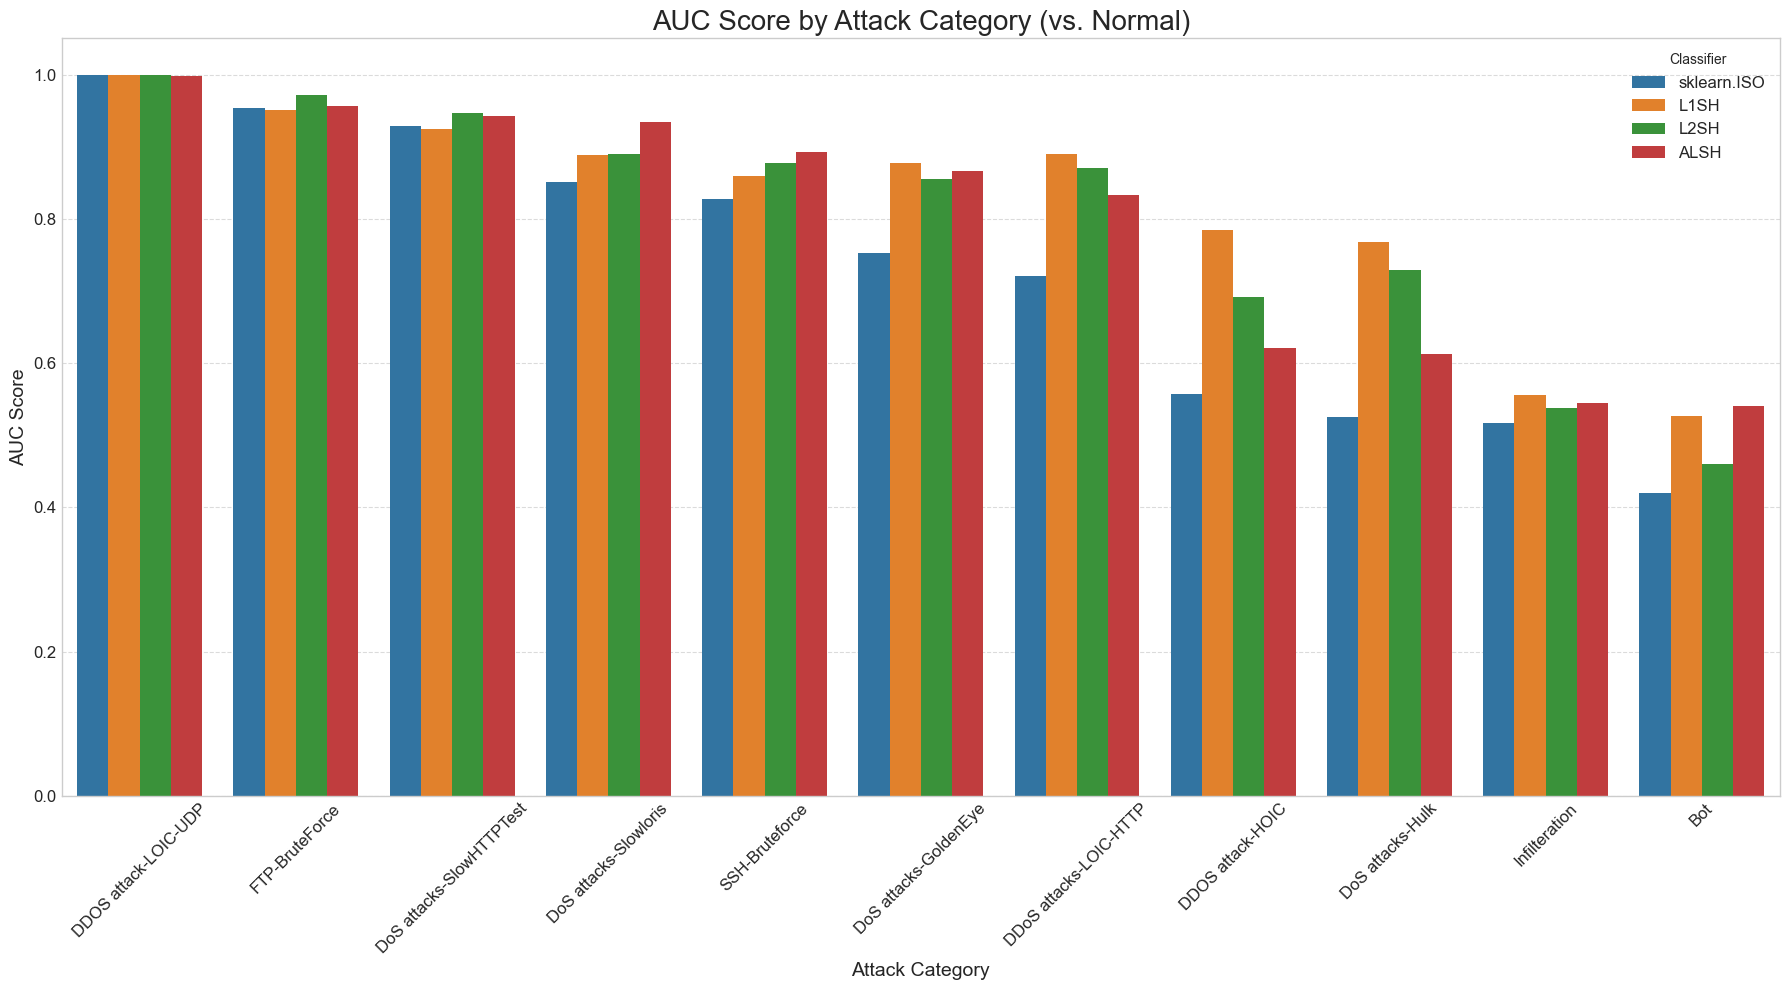

Corrected AUC Scores (Each Attack vs. Normal):
                          sklearn.ISO   L1SH   L2SH   ALSH
Bot                            0.4206 0.5262 0.4601 0.5412
DDOS attack-HOIC               0.5569 0.7847 0.6914 0.6208
DDOS attack-LOIC-UDP           1.0000 1.0000 0.9998 0.9977
DDoS attacks-LOIC-HTTP         0.7208 0.8904 0.8703 0.8328
DoS attacks-GoldenEye          0.7528 0.8776 0.8553 0.8658
DoS attacks-Hulk               0.5250 0.7681 0.7293 0.6129
DoS attacks-SlowHTTPTest       0.9293 0.9243 0.9462 0.9431
DoS attacks-Slowloris          0.8508 0.8879 0.8898 0.9348
FTP-BruteForce                 0.9541 0.9504 0.9719 0.9566
Infilteration                  0.5166 0.5565 0.5385 0.5455
SSH-Bruteforce                 0.8272 0.8600 0.8770 0.8930


In [ ]:
y_test = pd.Series(y_test)
results_df = pd.DataFrame(
    {'attack_cat': y_test_cat.values,'label': y_test.values}, 
    index=y_test.index)

for clf_name, clf in classifiers:
    clf.fit(X_train)
    y_pred = clf.decision_function(X_test)
    results_df[f'pred_{clf_name}'] = y_pred

normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

corrected_auc_scores = {}
for clf_name, _ in classifiers:
    scores = {}
    unique_attack_cats = sorted(attack_df['attack_cat'].unique())
    for cat in unique_attack_cats:
        current_attack_df = attack_df[attack_df['attack_cat'] == cat]
        eval_df = pd.concat([normal_df, current_attack_df])
        eval_preds = eval_df[f'pred_{clf_name}']
        eval_labels = eval_df['label']
        auc = roc_auc_score(eval_labels, -eval_preds)
        scores[cat] = auc
    corrected_auc_scores[clf_name] = scores

plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
category_order = plot_df_melted.groupby('Attack Category')['AUC Score'].mean().sort_values(ascending=False).index
sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax, order=category_order)
ax.set_title('AUC Score by Attack Category (vs. Normal)', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Classifier', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Corrected AUC Scores (Each Attack vs. Normal):")
pd.options.display.float_format = '{:.4f}'.format
results_table = pd.DataFrame(corrected_auc_scores).reindex(category_order, axis=0)
print(results_table)
plt.savefig(f"results/{datetime.today().strftime("%y%m%d")}cic_auc_by_category.png")

In [4]:
# dataのロード:unsw
X_train, y_train, X_test, y_test = dl.load_unsw_nb15()

print(len(X_train))
print(len(X_test))

56000
82332


In [ ]:
# UNSWで実験
for i, (clf_name, clf) in enumerate(classifiers):
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, -y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.6239269154776412
	Training time:	 0.13300776481628418
	Testing time:	 0.2107222080230713

L1SH:
	AUC score:	 0.7451530122507577
	Training time:	 7.489372968673706
	Testing time:	 66.20689415931702

L2SH:
	AUC score:	 0.7713520593411729
	Training time:	 7.019947052001953
	Testing time:	 93.41742491722107

ALSH:
	AUC score:	 0.750932001974621
	Training time:	 6.334143161773682
	Testing time:	 98.9474048614502


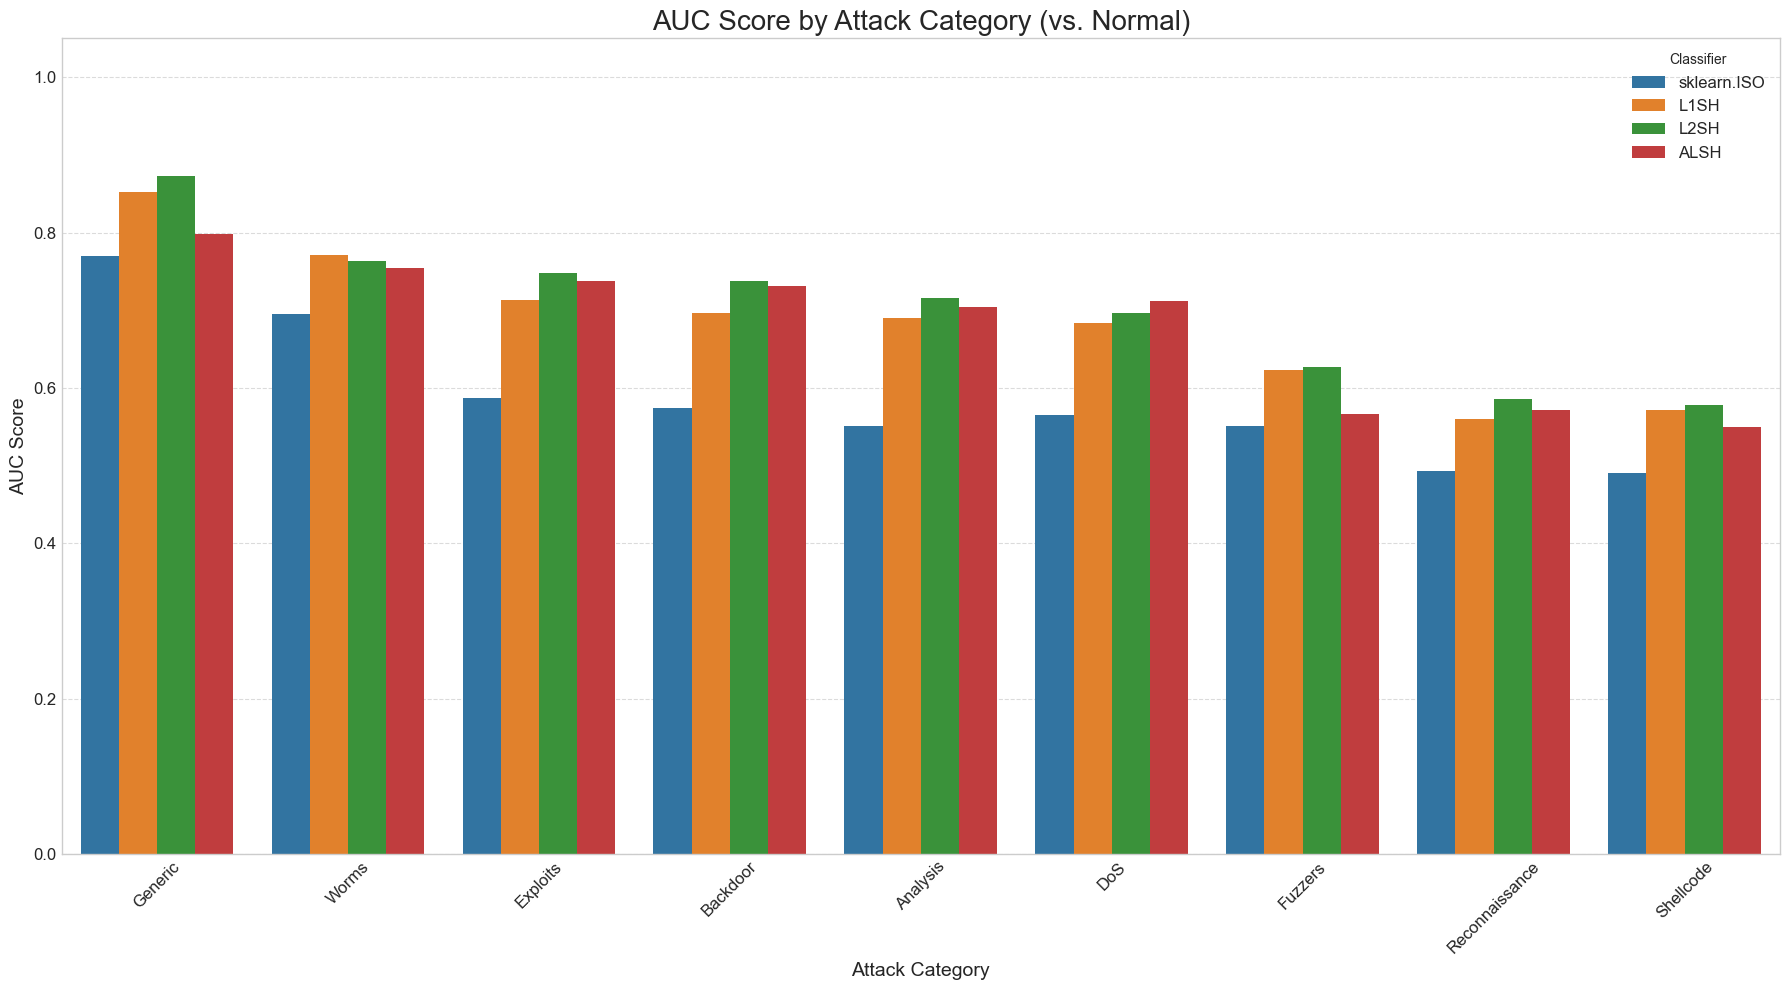

Corrected AUC Scores (Each Attack vs. Normal):
                sklearn.ISO   L1SH   L2SH   ALSH
Analysis             0.5507 0.6903 0.7159 0.7044
Backdoor             0.5740 0.6964 0.7376 0.7309
DoS                  0.5656 0.6832 0.6972 0.7122
Exploits             0.5878 0.7137 0.7484 0.7381
Fuzzers              0.5514 0.6230 0.6273 0.5661
Generic              0.7706 0.8520 0.8730 0.7982
Reconnaissance       0.4939 0.5608 0.5862 0.5721
Shellcode            0.4912 0.5717 0.5778 0.5505
Worms                0.6956 0.7710 0.7632 0.7551


In [ ]:
attack_cat_series = pd.read_csv('../data/unsw_nb15/UNSW_NB15_training-set.csv')['attack_cat']

results_df = pd.DataFrame({
'attack_cat': attack_cat_series.values,
'label': y_test.values
}, index=y_test.index)


for clf_name, clf in classifiers:
    clf.fit(X_train)
    y_pred = clf.decision_function(X_test)
    results_df[f'pred_{clf_name}'] = y_pred

normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

corrected_auc_scores = {}
for clf_name, _ in classifiers:
    scores = {}
    unique_attack_cats = sorted(attack_df['attack_cat'].unique())
    for cat in unique_attack_cats:
        current_attack_df = attack_df[attack_df['attack_cat'] == cat]
        eval_df = pd.concat([normal_df, current_attack_df])
        eval_preds = eval_df[f'pred_{clf_name}']
        eval_labels = eval_df['label']
        auc = roc_auc_score(eval_labels, -eval_preds)
        scores[cat] = auc
    corrected_auc_scores[clf_name] = scores

plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()
category_order = plot_df_melted.groupby('Attack Category')['AUC Score'].mean().sort_values(ascending=False).index
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax, order=category_order)
ax.set_title('AUC Score by Attack Category (vs. Normal)', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Classifier', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Corrected AUC Scores (Each Attack vs. Normal):")
pd.options.display.float_format = '{:.4f}'.format
results_table = pd.DataFrame(corrected_auc_scores).reindex(category_order, axis=0)
print(results_table)
plt.savefig(f"results/{datetime.today().strftime("%y%m%d")}unsw_auc_by_category.png")

In [5]:
# データの準備:nsl
X_train, y_train, X_test, y_test = dl.load_nsl_kdd()

print(f"Train data size :{len(X_train)}")
print(f"Test data size :{len(X_test)}")

Train data size :67343
Test data size :22544


In [ ]:
# nslで実験
for i, (clf_name, clf) in enumerate(classifiers):
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, -y_pred) # 反転
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.9114241684422666
	Training time:	 0.11903595924377441
	Testing time:	 0.06716012954711914

L1SH:
	AUC score:	 0.9145649246068066
	Training time:	 8.552365064620972
	Testing time:	 20.158140897750854

L2SH:
	AUC score:	 0.9153750231210545
	Training time:	 9.240540266036987
	Testing time:	 27.719343900680542

ALSH:
	AUC score:	 0.919441768937938
	Training time:	 7.9037158489227295
	Testing time:	 27.527488946914673



Training and Predicting with sklearn.ISO...

Training and Predicting with ALSH...

Training and Predicting with L2SH...

Training and Predicting with L1SH...

--- All predictions are stored in results_df ---


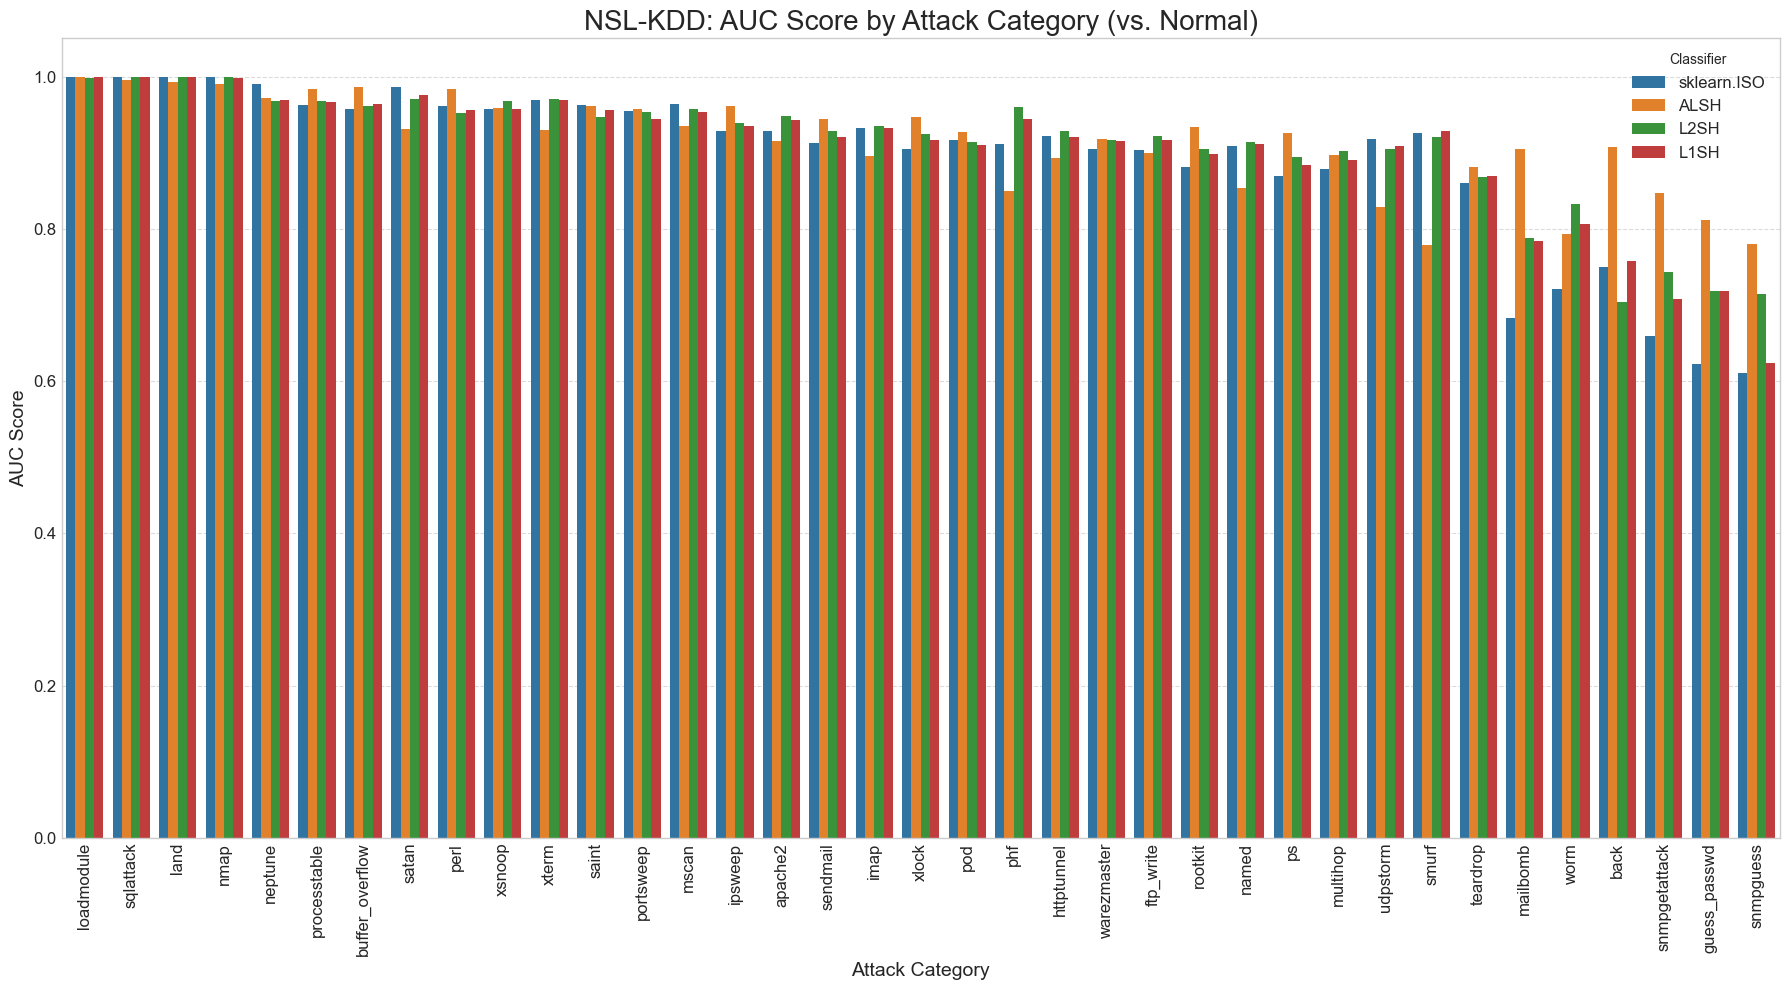


Corrected AUC Scores for NSL-KDD (Each Attack vs. Normal):
                 sklearn.ISO   ALSH   L2SH   L1SH
Attack Category                                  
loadmodule            0.9989 0.9998 0.9982 0.9989
sqlattack             0.9994 0.9958 0.9990 0.9997
land                  0.9995 0.9931 0.9997 0.9999
nmap                  0.9990 0.9908 0.9997 0.9987
neptune               0.9896 0.9718 0.9682 0.9693
processtable          0.9627 0.9841 0.9684 0.9661
buffer_overflow       0.9569 0.9859 0.9618 0.9635
satan                 0.9868 0.9313 0.9708 0.9756
perl                  0.9617 0.9831 0.9516 0.9561
xsnoop                0.9574 0.9589 0.9678 0.9576
xterm                 0.9694 0.9301 0.9710 0.9691
saint                 0.9623 0.9614 0.9464 0.9564
portsweep             0.9542 0.9574 0.9538 0.9447
mscan                 0.9633 0.9352 0.9571 0.9540
ipsweep               0.9282 0.9614 0.9385 0.9352
apache2               0.9287 0.9152 0.9485 0.9435
sendmail              0.9122 0.9441 0.92

In [ ]:
# nslの攻撃種別の結果の表示
test_df_for_cat = pd.read_csv('../data/nsl_kdd/KDDTest+.txt', header=None, names=config.columns_nsl)
attack_cat_series = test_df_for_cat['class'].str.strip()

results_df = pd.DataFrame({
    'attack_cat': attack_cat_series.values,
    'label': y_test.values
}, index=y_test.index)

for clf_name, clf in classifiers:
    clf.fit(X_train)
    y_pred = clf.decision_function(X_test)
    results_df[f'pred_{clf_name}'] = y_pred

normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

corrected_auc_scores = {}
for clf_name, _ in classifiers:
    scores = {}
    unique_attack_cats = sorted([cat for cat in attack_df['attack_cat'].unique() if cat != 'normal'])
    for cat in unique_attack_cats:
        current_attack_df = attack_df[attack_df['attack_cat'] == cat]
        eval_df = pd.concat([normal_df, current_attack_df])
        eval_preds = eval_df[f'pred_{clf_name}']
        eval_labels = eval_df['label']
        
        if len(eval_labels.unique()) > 1:
            auc = roc_auc_score(eval_labels, -eval_preds) # 反転
            scores[cat] = auc
        else:
            scores[cat] = None
    corrected_auc_scores[clf_name] = scores

plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()
category_order = plot_df_melted.groupby('Attack Category')['AUC Score'].mean().sort_values(ascending=False).index

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax, order=category_order)

ax.set_title('NSL-KDD: AUC Score by Attack Category (vs. Normal)', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=90, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title='Classifier', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"results/{datetime.today().strftime("%y%m%d")}nsl_kdd_auc_by_category.png")
plt.show()

print("\nCorrected AUC Scores for NSL-KDD (Each Attack vs. Normal):")
pd.options.display.float_format = '{:.4f}'.format
results_table = pd.DataFrame(corrected_auc_scores).reindex(category_order, axis=0) 
print(results_table)